# Entrenamiento de clasificador de imagenes mediante Transfer Learning

## Introduccion

Para entrenar un clasificador de imagenes desde cero que aprenda sin sobreajuste, se requiere el uso de millones de imagenes.
Por lo que es mas practico utilizar un modelo pre-entrenado con algun dominio general y ajustar los pesos al problema especifico a evaluar.

Dentro de este notebook, vamos a entrenar una arquitectura ResNet34 con imágenes de una base de datos de imagenes médicas estandarizadas, para aprender a como entrenar y evaluar un clasificador con una Red Neuronal Profunda.

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms
from torchvision.models import resnet34
from torchvision.ops import sigmoid_focal_loss

# Para estimar metricas
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score, MultilabelAUROC
from sklearn import metrics

# Para hacer barras de progreso
from tqdm import tqdm

# Dataset
from medmnist import ChestMNIST



In [2]:
### Parametros Iniciales

# Si tu equipo contiene una GPU con CUDA:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU disponible')
# Si tu equipo es mac con AppleSilicon:
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Acelerador MPS disponible')
# O en CPU como la plebe:
else:
    device = torch.device('cpu')
    print('CPU disponible')

GPU disponible


En la siguiente celda, definiremos algunos parametros importantes para entrenar nuestro modelo.

Mas adelante explicaremos en detalle estos

In [9]:
n_epochs = 20 # numero de epocas o iteraciones completas del dataset para entrenar el modelo
batch_size = 48 # numero de ejemplos que se usan para calcular el gradiente en cada iteracion
lr = 1e-4 # tasa de aprendizaje
n_labels = 14 # numero de etiquetas en el dataset

# modelo
Vamos a cargar nuestro modelo ResNet34, con la diferencia de que ahora no necesitamos que tenga 1000 clases, sino que la cantidad de etiquetas que tiene nuestro conjunto.
Por lo que vamos a modificar el modelo en su capa de salida

![ResNet34](../etc/resnet34.jpg)

In [4]:
modelo = resnet34(weights='DEFAULT') # Cargamos el modelo preentrenado
modelo.fc = nn.Linear(512, n_labels) # Cambiamos la capa de salida para que tenga 14 neuronas
modelo = modelo.to(device) # lo cargamos a nuestra GPU

In [5]:
# optimizador
optimizador = optim.Adam(modelo.parameters(), lr=lr)

# Transformaciones

Tambien definiremos el proceso de transformaciones a realizar a nuestras imagenes.
Este proceso se realiza para evitar que el algoritmo se aprenda de memoria las imagenes de entrenamiento (_overfitting_).

El objetivo es pasarle variaciones pequeñas a la imagen que fuercen al modelo a aprender caracteristicas mas amplias del modelo.

Este proceso **solo** se aplica en entrenamiento. 
Nos interesa que los datos de validacion y test tengan caracteristicas mas estables, para poder identificar si el modelo logró generalizar de forma correcta.
Por lo mismo, en los datos de validación y test solo ajustamos la imagen para que pueda ser ingresada al modelo (cambiar el tipo de la imagen)

In [6]:
# Transformacion para entrenamiento
train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToDtype(torch.float32, scale=True),
])

# Transformacion para test
test_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

## Dataset medMNIST

El dataset [medMNIST](https://github.com/MedMNIST/MedMNIST) es un conjunto de datasets de prueba, estandarizados, enfocados en problemas de clasificación de imágenes biomedicas en 2D y 3D.

Dentro de sus caracteristicas, posee versiones de imagenes para ejemplos pequeños `28x28`, hasta `224x224`
Imagenes 2D y 3D 

Posee ejemplos de tejido de colon con patologías, Rayos X de pecho, Dermatoscopia, Retina, Fondo de ojo, Analisis de celulas sanguineas, imagenes de tomografía abdominal, etc.

### ChestMNIST
Este subconjunto utiliza la base de datows `ChestX-Ray14`, la que contiene alrededor de 112120 imagenes de rayos X frontales. con 30805 pacientes..
Las clases presentes en este conjunto son: 
Atelectasis, Cardiomegalia, Efusión, Infiltración, Masa, Nodulo, Neumonia, Neumotorax, Consolidación, Edema, Enfisema, Fibrosis, Engrosamiento Pleural, Hernia|

In [7]:
label_names = ["Atelectasis", "Cardiomegalia", "Efusión", "Infiltración", "Masa", "Nodulo", "Neumonia", "Neumotorax", "Consolidación", "Edema", "Enfisema", "Fibrosis", "Engrosamiento Pleural", "Hernia"]

Vamos a configurar las imagenes, medMNIST ofrece un objeto que contiene el par imagen, etiqueta de forma separada.
Le vamos a indicar que usaremos imagenes de tamaño 224x224, que las deje con 3 canales (RGB), y le pasaremos las transformaciones, de modo que al iterar nos entregue los tensores listos.

In [8]:
# Conjunto Train
donwload = False # Si no tienes el dataset descargado, ponlo en True (solo la primera vez)
train_dataset = ChestMNIST(split='train', download=donwload, size=224, as_rgb=True, transform=train_transforms)
# Conjunto Validation
valid_dataset = ChestMNIST(split='val', download=donwload, size=224, as_rgb=True, transform=test_transforms)
# Conjunto Test
test_dataset = ChestMNIST(split='test', download=donwload, size=224, as_rgb=True, transform=test_transforms)

Vamos a visualizar un ejemplo del conjunto de validación.
Como la imagen es ahora un tensor, de tamaño `(canales, ancho, largo)`, es necesario transponer la matriz y volverla un array de numpy para poder presentarla.

(-0.5, 223.5, 223.5, -0.5)

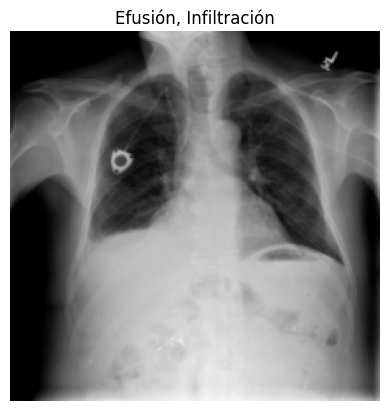

In [10]:
image, label = valid_dataset[24]
image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
present_labels = [label_names[lab] for lab in np.nonzero(label)[0]]
if present_labels:
    plt.title(', '.join(present_labels))
else:
    plt.title('No label')

#plt.title(label)
plt.axis('off')

Vamos a visualizar como esta distribuido este conjunto. El conjunto ChestMNIST contiene una o varias etiquetas de patologias presentes a nivel pulmonar.
Las imagenes sanas presentan en su vector de etiqueta solo 0. Por lo que los contaremos de forma separada.

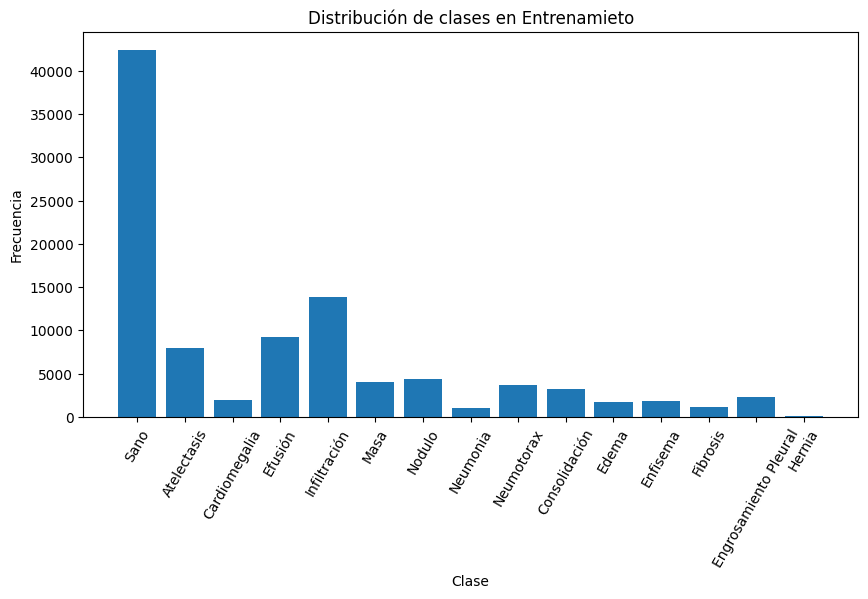

In [11]:
# Visualización de la distribución de clases en conjunto de entrenamiento

all_labels = train_dataset.labels # Matriz de etiquetas

conteos = all_labels.sum(axis=0) # Cantidad de muestras por clase
sanos = sum(all_labels.sum(axis=1) == 0) # Cantidad de muestras sanas

## Grafico
fig, ax = plt.subplots(figsize=(10, 5))
idx_clases = np.arange(len(conteos)+1)
ax.bar(idx_clases, np.append(sanos, conteos))
ax.set_title('Distribución de clases en Entrenamieto')
ax.set_xlabel('Clase')
ax.set_ylabel('Frecuencia')
ax.set_xticks(idx_clases, ['Sano'] + label_names, rotation=60, va='top', ha='center')

## Dataloader
Pytorch para facilitar el proceso de mezclar y separar los datos, provee DataLoaders.
Los Dataloaders son objetos que permiten automatizar el muestreo de nuestros datos, generando nuestros batches de entrenamiento, mezclar los datos, paralelizar este proceso para acelerar el proceso de creacion de nuestras muestras, etc.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

## Metricas de entrenamiento

Una forma de evaluar si el modelo esta aprendiendo es si la función de costo disminuye.
Pero esto no indica si el modelo esta aprendiendo correctamente. Para esto se utilizan metricas que comparan que tan correcto es comparado con las etiquetas reales del conjunto

Como estamos evaluando un problema de multiples etiquetas, vamos a usas funciones de exactitud que estime la exactitud promedio dentro de todas las etiquetas.

Usaremos la libreria `torchmetrics`, que es una libreria que provee metricas adaptadas para el flujo de trabajo con pytorch, ofreciendo para problemas tanto binarios, multiclase o multietiqueta.

In [13]:
acc_metric = MultilabelAccuracy(num_labels=14, average='micro').to(device)
f1_metric = MultilabelF1Score(num_labels=14, average='micro').to(device)
auc_metric = MultilabelAUROC(num_labels=14, average='micro').to(device)

## ciclo de entrenamiento 
Esto tomara un tiempo (en especial si no tienen GPU)

In [14]:
for epoch in range(n_epochs):
    print(f'Epoca {epoch+1}/{n_epochs}')
    ############################
    # Ciclo de entrenamiento
    modelo.train()
    pbar = tqdm(total=len(train_loader), desc='Train') # Barra de progreso
    for images, labels in train_loader:
        # Movemos las imagenes y etiquetas a la GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        optimizador.zero_grad() # Limpiamos los gradientes
        output = modelo(images) # Pasamos las imagenes por el modelo
        loss = sigmoid_focal_loss(output, labels.float(), alpha=0.3, reduction='mean') # Calculamos la perdida

        # Backward
        loss.backward()
        optimizador.step()

        # Metricas
        current_acc = acc_metric(output, labels)
        current_f1 = f1_metric(output, labels)
        current_auc = auc_metric(output, labels)

        pbar.update(1)
        pbar.set_postfix_str(f'Loss={loss.item():.4f} - Acc={current_acc.item():.2%} - F1={current_f1.item():.3f} - AUC={current_auc.item():.3f}')
    
    pbar.close() # Cerramos la barra de progreso
    # Limpiamos las metricas
    acc_metric.reset()
    f1_metric.reset()
    auc_metric.reset()

    ############################
    # Ciclo de validación
    modelo.eval()
    pbar = tqdm(total=len(valid_loader), desc='Valid') # Barra de progreso
    with torch.no_grad():
        for images, labels in valid_loader:
            # Movemos las imagenes y etiquetas a la GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward
            output = modelo(images)

            # Metricas
            current_acc = acc_metric(output,labels)
            current_f1 = f1_metric(output, labels)
            current_auc = auc_metric(output, labels)
        
            pbar.update(1)
    pbar.close()
    valid_acc = acc_metric.compute()
    valid_f1 = f1_metric.compute()

    print(f'Metricas de Validación Epoca {epoch+1} :')
    print(f'Acc={valid_acc.item():.2%} - F1={valid_f1.item():.2%} - AUC={current_auc.item():.3f}')
    print()

    acc_metric.reset()
    f1_metric.reset()
    auc_metric.reset()

# Finalmente, guardamos el modelo
torch.save(modelo, '../modelo.pth')
print('Modelo guardado')       

Epoca 1/20


Train:  88%|████████▊ | 1442/1635 [01:29<00:13, 14.73it/s, Loss=0.0181 - Acc=93.90% - F1=0.000 - AUC=0.871]

## Evaluacion

Para poder comprobar si nuestro modelo aprendió a generalizar el problema de forma correcta, se evalua con imagenes desconocidas por este.
Estas son las imagenes del conjunto de test.

A continuación, se presenta un resumen de las metricas reportadas por los autores, utilizando modelos ResNet18 y ResNet50

| Arquitectura | Accuracy | AUROC |
|:---:|:---:|:---:|
| Resnet18 (28x28)   | 0.947 | 0.768 |
| Resnet18 (224x224) | 0.947 | 0.773 |
| Resnet50 (28x28)   | 0.947 | 0.769 |
| Resnet50 (224x224) | 0.948 | 0.773 |


In [ ]:
# Para cargar el modelo ya entrenado en otra ocasion
#modelo = resnet34(weights='DEFAULT')
#modelo.load_state_dict()

modelo = torch.load('../modelo.pth', map_location=device)
modelo.eval()

In [14]:
# Test
all_labels = []
all_preds = []

acc_metric.reset()
f1_metric.reset()
auc_metric.reset()

with torch.no_grad():
    modelo.eval()
    pbar = tqdm(total=len(test_loader), desc='Test') # Barra de progreso
    for images, labels in test_loader:
        # Movemos las imagenes y etiquetas a la GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        output = modelo(images)
        pred = torch.sigmoid(output) 

        # Metricas
        all_labels.append(labels.cpu().numpy())
        all_preds.append(pred.detach().cpu().numpy())
        acc_metric.update(output, labels)
        f1_metric.update(output, labels)
        auc_metric.update(output, labels)

        pbar.update(1)
        
    pbar.close()
    test_acc = acc_metric.compute()
    test_f1 = f1_metric.compute()
    test_auc = auc_metric.compute()

    print(f'Metricas de Test:')
    print(f'Acc={test_acc.item():.2%} - F1={test_f1.item():.2%} - AUC={test_auc.item():.3f}')
    print()

Test: 100%|██████████| 624/624 [00:23<00:00, 26.44it/s]


Metricas de Test:
Acc=94.84% - F1=9.02% - AUC=0.873



Obtenemos la precisión y el AUC de nuestro modelo. Que tan bien se desempeña comparado con lo reportado?

#### A considerar
- Este modelo lo entrenamos a 20 epocas y con una tasa de aprendizaje arbitraria.
- El detalle de los parametros de entrenamiento generalmente es reportado con el objetivo de indicar las condiciones que permiten replicar el funcionamiento reportado (en condiciones ideales).
- la precisión de un modelo no depende solamente de la exactitud.

In [15]:
# Transformamos las listas en arrays para evaluar las métricas
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

print(all_labels.shape, all_preds.shape)

(22433, 14) (22433, 14)


El Reporte de clasificación es un resumen que nos permite ver la precisión, sensibilidad y F1 score por clase.
Tambien reporta los desempeños promedio del conjunto, a nivel micro, macro, junto con promedio por clase.

In [16]:
# Classification report
report = metrics.classification_report(all_labels, all_preds > 0.5, target_names=label_names)
print(report)

                       precision    recall  f1-score   support

          Atelectasis       0.55      0.04      0.07      2420
        Cardiomegalia       0.63      0.05      0.10       582
              Efusión       0.69      0.18      0.29      2754
         Infiltración       0.54      0.00      0.01      3938
                 Masa       0.54      0.04      0.07      1133
               Nodulo       0.64      0.01      0.01      1335
             Neumonia       0.00      0.00      0.00       242
           Neumotorax       0.54      0.04      0.07      1089
        Consolidación       0.67      0.00      0.00       957
                Edema       0.60      0.01      0.03       413
             Enfisema       0.49      0.13      0.20       509
             Fibrosis       0.33      0.00      0.01       362
Engrosamiento Pleural       0.00      0.00      0.00       734
               Hernia       0.71      0.12      0.20        42

            micro avg       0.62      0.05      0.09 

/home/caribu/miniconda3/envs/tallercnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/caribu/miniconda3/envs/tallercnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/caribu/miniconda3/envs/tallercnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

Vamos a visualizar la matriz de confusion:

La matriz de confusion muestra con respecto a cada etiqueta si le acierta o no a esta.
Obtenemos si el modelo comete errores de tipo I o II

(-0.5, 1.5, 1.5, -0.5)

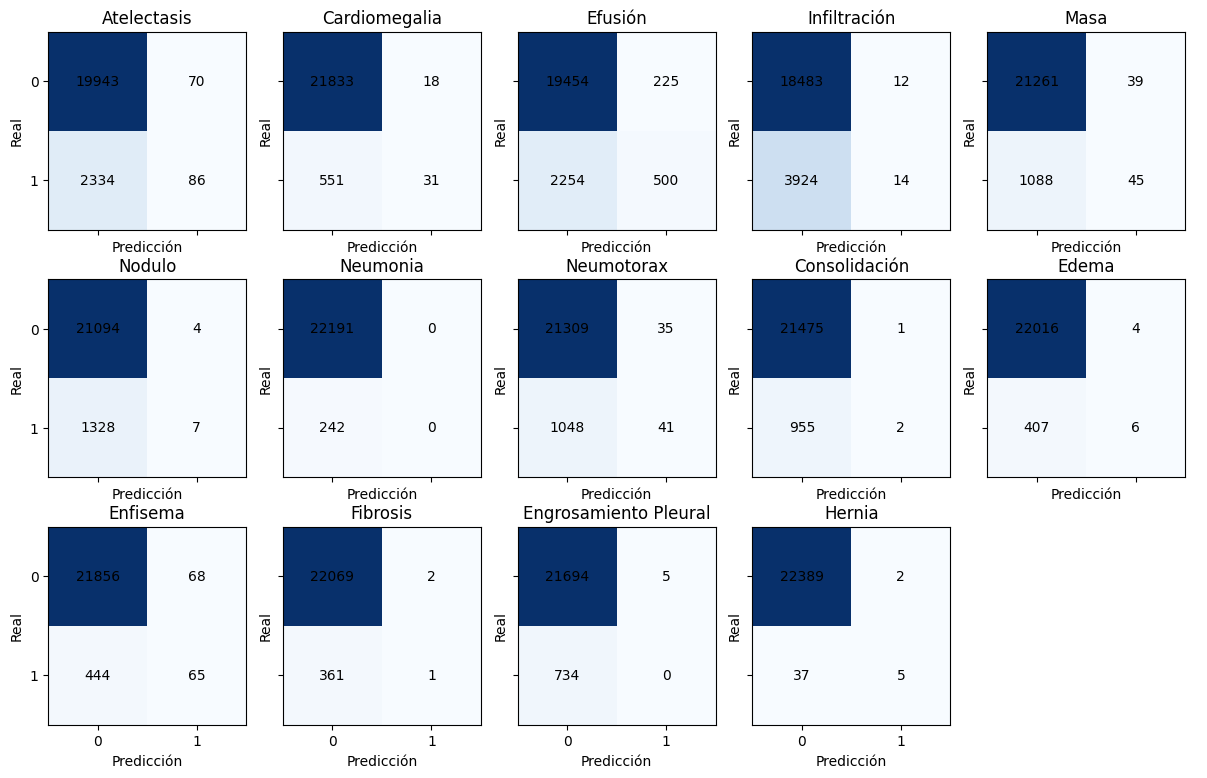

In [17]:
cm = metrics.multilabel_confusion_matrix(all_labels, all_preds > 0.5)

plot_struct = [
    ["Atelectasis", "Cardiomegalia", "Efusión", "Infiltración", "Masa"], 
    ["Nodulo", "Neumonia", "Neumotorax", "Consolidación", "Edema"], 
    ["Enfisema", "Fibrosis", "Engrosamiento Pleural", "Hernia", 'null'],
]

fig = plt.figure(figsize=(15, 9))
axes = fig.subplot_mosaic(plot_struct, sharex=True, sharey=True, gridspec_kw={'hspace': 0.25, 'wspace': 0.05})

for i, label_name in enumerate(label_names):
    axes[label_name].imshow(cm[i], cmap='Blues')
    axes[label_name].set_title(label_name)
    axes[label_name].set_xlabel('Predicción')
    axes[label_name].set_ylabel('Real')
    axes[label_name].set_xticks([0, 1])
    axes[label_name].set_yticks([0, 1])
    for j in range(2):
        for k in range(2):
            axes[label_name].text(k, j, f'{cm[i][j, k]:.0f}', ha='center', va='center', color='black')
        
    
axes['null'].axis('off')

Las Curvas ROC permiten evaluar que tan bien el modelo es capaz de identificar. Mediante el analisis del cuantos verdaderos positivos vs falsos positivos hay a distintos niveles de aceptación (a que probabilidad decimos que pertenece o no a la clase)

La curva de Precision-Sensibilidad hace algo similar, pero evaluando que tan bueno es el modelo para identificar correctamente un caso.

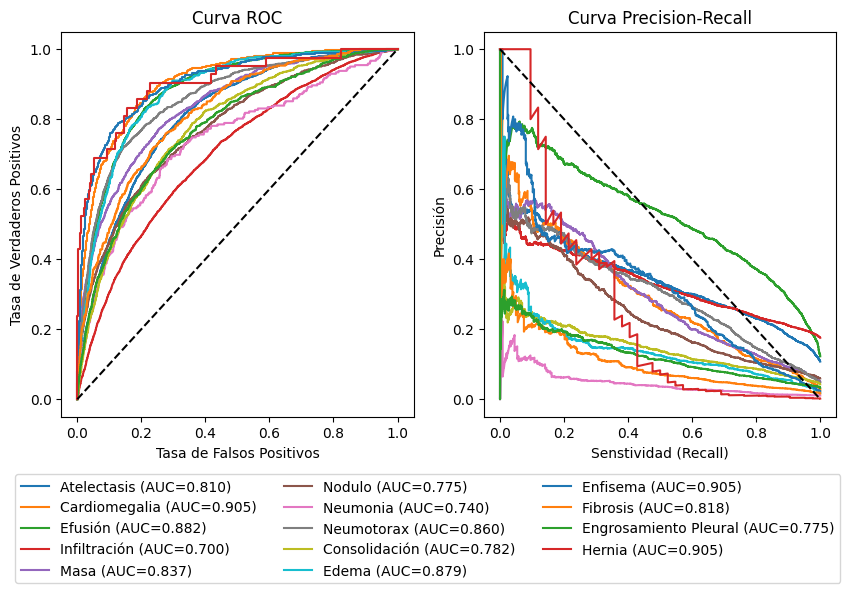

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

#Curva ROC
for i, label in enumerate(label_names):
    fpr, tpr, thresh = metrics.roc_curve(all_labels[:, i], all_preds[:, i])
    auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, label=f'{label} (AUC={auc:.3f})')

    precision, recall, thresh = metrics.precision_recall_curve(all_labels[:, i], all_preds[:, i])
    ax[1].plot(recall, precision, label=label)

ax[0].plot([0, 1], [0, 1], 'k--')
ax[1].plot([0, 1], [1, 0], 'k--')
ax[0].set(
    xlabel='Tasa de Falsos Positivos',
    ylabel='Tasa de Verdaderos Positivos',
    title='Curva ROC'
)
ax[1].set(
    xlabel='Senstividad (Recall)',
    ylabel='Precisión',
    title='Curva Precision-Recall',
)


ax[0].legend(loc='lower left', bbox_to_anchor=(-.15, -0.45), fancybox=True, ncol=3)
#ax[1].legend()

## Referencias 

> Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. Yang, Jiancheng, et al. "MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification." Scientific Data, 2023.

> Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.
